In [ ]:
import torch
from Utils import OurModel, MyClass, myCustomTransform, encode_segmap, decode_segmap, inv_normalize
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import cv2

DATA_DIR = "~/data/cityscapes/"
model_weights_dir = "./weights/"
model_name = "model-bnet-one-day.pth"

In [ ]:
model = OurModel()
model.load_state_dict(torch.load(model_weights_dir+model_name))

In [ ]:
test_class = MyClass(DATA_DIR, split='val', mode='fine',
                     target_type='semantic',transforms=myCustomTransform)
test_loader = DataLoader(test_class, batch_size=1, 
                      shuffle=False)

In [ ]:
## INFERENCE

## SELECT DEVICE TO RUN THE INFERENCE ON

device = 'cpu'
# device = 'gpu'

if device == 'gpu':
    model=model.cuda()
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            img,seg = batch
            output = model(img.cuda())
            break
    print(img.shape,seg.shape,output.shape)    
else:
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            img,seg = batch
            print(f"{img.shape=}")
            output = model(img)
            break
    print(img.shape, seg.shape, output.shape)    

In [ ]:
def truthMaskToView(segMask):
    '''
    converts the model output segmentation mask into view mode
    applies: (encode, decode)
    Returns a copy of the segMask for view
    '''
    return decode_segmap(encode_segmap(segMask.clone()))

In [ ]:
def rawOutputToMask(modelOutput):
    '''
    converts the raw model output to the segmentation mask ready to view.
    assume modelOutput is on CPU
    assume modelOutput shape is of [N, 20, 256, 512] where N is batch size
    '''
    return decode_segmap(torch.argmax(modelOutput.detach(), 0))

In [ ]:
def plotThing(image, mask_truth, mask_predict):
    '''
    assume image and all masks aare on the cpu and NOT on the gpu.
    assume image is already inverted and all masks are decoded.
    '''
    fig,ax=plt.subplots(1,3,figsize=(10,5),facecolor='white')  
    if isinstance(image, type(torch.tensor)):
        ax[0].imshow(np.moveaxis(image.numpy(),0,2)) #(3,256, 512)
    else:
        # ax[0].imshow(np.moveaxis(image,0,2)) #(3,256, 512)
        ax[0].imshow(image)
    ax[1].imshow(mask_truth) #(256, 512, 3)
    ax[2].imshow(mask_predict) #(256, 512, 3)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].set_title('Input Image')
    ax[1].set_title('Ground mask')
    ax[2].set_title('Predicted mask')

In [ ]:
%matplotlib widget

for sample in range(img.shape[0]):
    image = inv_normalize(img[sample])
    print(f"{image.shape=}")
    mask_truth = truthMaskToView(seg[sample])
    print(f"{output[sample].shape}")
    mask_predict = rawOutputToMask(output[sample])

    plotThing(image, mask_truth, mask_predict)

    break

## Let's try an out of distribution image.

In [ ]:
def removeAlphaChannel(img : np.ndarray) -> np.ndarray:
    if img.shape[2] == 4:
        return img[:,:,:3]

In [ ]:
testUserImage = plt.imread("./data/outOfBagImg.png")

# remove the alpha channel
testUserImage = removeAlphaChannel(testUserImage)
print(testUserImage.shape)

plt.figure()
plt.imshow(testUserImage)

raw image -> transform -> model -> raw seg -> rawOutputToMask -> segmentation mask is ready to view.
raw image -> ready to view

In [ ]:
def prepare_image(img):
    # Resize the image preserving the aspect ratio
    target_height = 256
    target_width = 512
    height, width, _ = img.shape
    scale = min(target_height / height, target_width / width)
    new_height = int(height * scale)
    new_width = int(width * scale)
    resized_img = cv2.resize(img, (new_width, new_height))
    
    # Pad the image to the required size
    pad_height = (target_height - new_height) // 2
    pad_width = (target_width - new_width) // 2
    padded_img = cv2.copyMakeBorder(resized_img, pad_height, target_height - new_height - pad_height,
                                    pad_width, target_width - new_width - pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # move the color dimension
    padded_img = np.moveaxis(padded_img, 2, 0)

    # # Normalize the image
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    padded_img = (padded_img - mean) / std
    
    # Add the batch dimension
    batch_img = np.expand_dims(padded_img, axis=0)

    return batch_img

In [ ]:
tmp = prepare_image(testUserImage)
tmp = tmp.astype(np.float32)
inputImg = torch.tensor(tmp)
print(inputImg.shape)

In [ ]:
model.eval()
output = model(inputImg)
output.shape

In [ ]:
# view the user image and the model's segmentation mask

image = inv_normalize(inputImg[0])
mask_truth = np.zeros((256, 512))
mask_predict = rawOutputToMask(output[0])

plotThing(image, mask_truth, mask_predict)

## Try another out of bag image -- This time from GTA V

In [ ]:
plt.figure()
gta5_img = plt.imread('./data/gta5_street.png')
gta5_img = removeAlphaChannel(gta5_img)
plt.imshow(gta5_img)

In [ ]:
def inference_pipeline(model, image):
    '''
    Full inference pipeline testing.
    '''
    # prepare the image (a whole lot of stuff, refer to the functin for actual steps)
    tmp = prepare_image(image)
    tmp = tmp.astype(np.float32)
    inputImg = torch.tensor(tmp)

    # pass through the model
    model.eval()
    output = model(inputImg)

    return output, inputImg

In [ ]:
output, inputImg = inference_pipeline(model, gta5_img)

image = inv_normalize(inputImg[0])
mask_truth = np.zeros((256, 512))
mask_predict = rawOutputToMask(output[0])

plotThing(image, mask_truth, mask_predict)

## Now using the InferenceWorker class:

In [1]:
from Utils import InferenceWorker, plotThreeImages
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
MODEL_WEIGHTS_PATH='./weights/model-bnet-one-day.pth'
inferenceWorker = InferenceWorker(model_weights_path=MODEL_WEIGHTS_PATH)

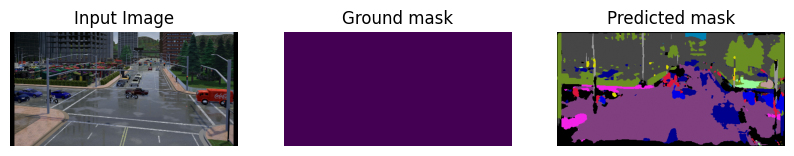

In [3]:
rawImage = plt.imread('/home/wang/Downloads/road_test.png')

mask_truth = np.zeros((256, 512))
mask_predict, input_img_resized = inferenceWorker.segment(rawImage)

plotThreeImages(input_img_resized, mask_truth, mask_predict)

In [ ]:
rawImage.min(), rawImage.max()

In [ ]:
plt.hist([p for row in mask_predict for col in row for p in col])

In [ ]:
mask_predict.min(), mask_predict.max()

In [ ]:
mask_pred = (mask_predict * 255).astype('uint8')
plt.figure()
plt.imshow(mask_pred)

In [ ]:
mask_pred.min(), mask_pred.max()

In [ ]:
plt.figure()
plt.hist([p for row in mask_pred for col in row for p in col])